In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
DS = tf.keras.preprocessing.image_dataset_from_directory('./dataset/',validation_split=0.2,subset='training',seed=42)

Found 202 files belonging to 2 classes.
Using 162 files for training.


In [3]:
train_ds=DS

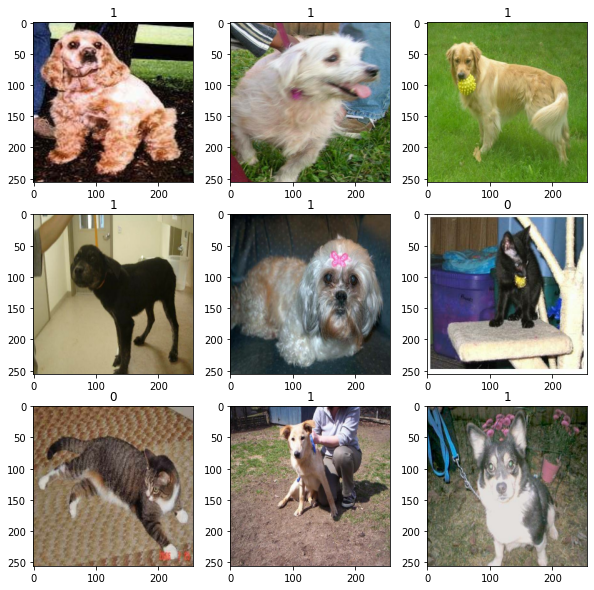

In [4]:
for p in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(p[0][i]).astype(int))
        plt.title(int(p[1][i]))
#         plt.axis("off")

In [5]:
base_model = keras.applications.vgg16.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(250, 250, 3),
    include_top=False,
) 

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

In [7]:
inputs = keras.Input(shape=(256, 256, 3))

x=base_model(inputs,training=False)

new_model = keras.layers.GlobalMaxPooling2D()(x)
new_model = keras.layers.Activation(keras.activations.softmax)(new_model)
model = keras.Model(inputs, x)
model2 = keras.Model(inputs, new_model)

In [8]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [10]:
res = model2.predict(train_ds)

In [11]:
res.shape

(162, 512)

In [12]:
for f in train_ds.as_numpy_iterator():
    print(f[0].shape)
    dt = f[0]
    print("_______________")
    print(f[1])
    yt = f[1]
    print("-------------------")
    break
    

(32, 256, 256, 3)
_______________
[1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
-------------------


In [13]:
rest = model2.predict(dt)

In [14]:
rest.shape,dt.shape,yt.shape

((32, 512), (32, 256, 256, 3), (32,))

In [15]:
corr = []
for v in range(512):
#     print(v,np.corrcoef(yt,rest[:,v])[0,1])
    corr.append(np.corrcoef(yt,rest[:,v])[0,1])
# corr = [c if c != np.NAN else 0 for c in corr ]
corr=np.nan_to_num(np.array(corr))

/home/t1tl/miniconda3/envs/yoloT3/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/t1tl/miniconda3/envs/yoloT3/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [16]:
res.shape

(162, 512)

In [17]:
import numpy as np

In [18]:
senset = np.sum(res,axis=0)

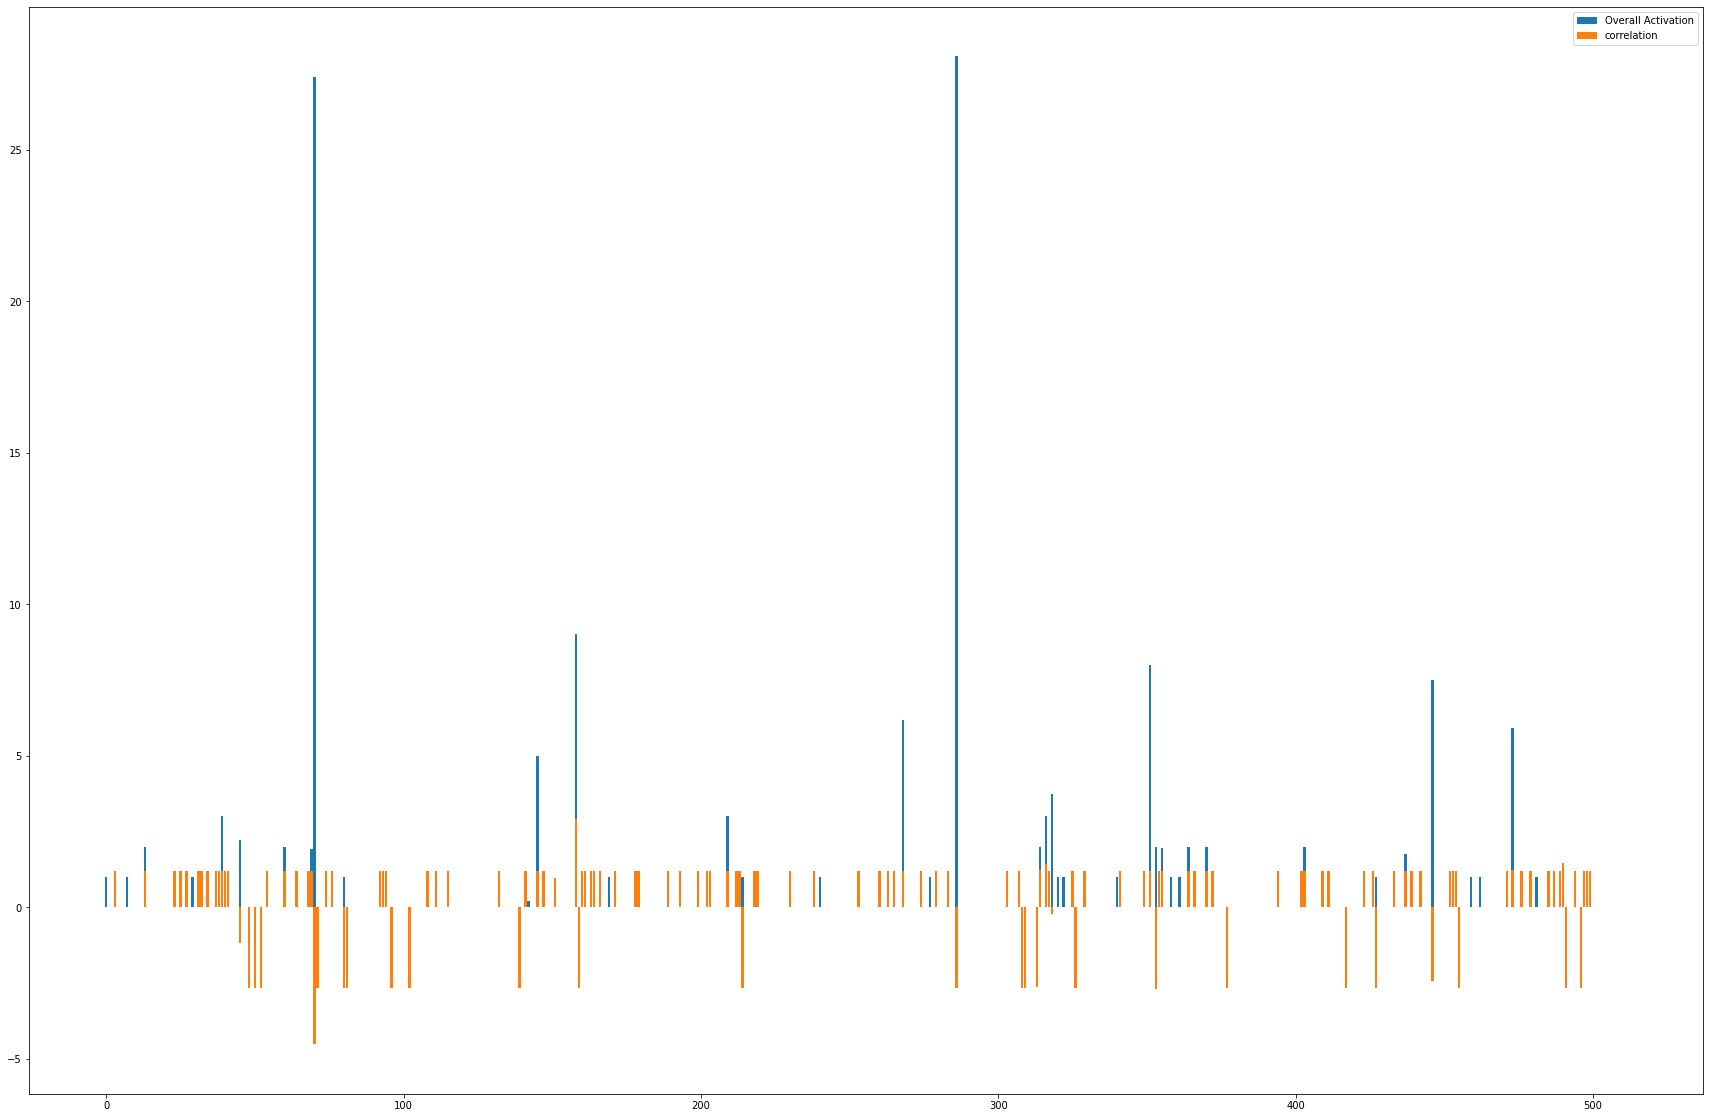

In [22]:
plt.figure(figsize=(30,20))
plt.bar(list(range(len(senset))),senset, label ="Overall Activation")
plt.bar(list(range(512)),corr*10,label="correlation")
plt.legend()

In [23]:
interestA = senset.argsort()[-10:]
interestC = np.abs(corr).argsort()[-10:]

In [24]:
interestA,interestC

(array([316, 318, 145, 473, 268, 446, 351, 158,  70, 286]),
 array([326,  96,  50, 377, 491, 427, 286, 353, 158,  70]))

In [83]:
np.array(p[0][0]).astype(int).shape

(256, 256, 3)

In [26]:
b = train_ds.take(1)

In [27]:
b.batch(1)

<BatchDataset shapes: ((None, None, 256, 256, 3), (None, None)), types: (tf.float32, tf.int32)>

In [28]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import cv2

In [29]:
p[0][1].shape

TensorShape([256, 256, 3])

In [30]:
def plotInterest(interest,imagenum):
    fig, axes = plt.subplots(nrows=2, ncols=5)
    cmap=cm.get_cmap('viridis')
    normalizer=Normalize(0,300)
    acts = np.zeros((8,8))
    im=cm.ScalarMappable(norm=normalizer)
    images = list(train_ds.take(1).as_numpy_iterator())
    print(images[0][1])
    t = np.expand_dims(images[0][0][imagenum].astype(int), axis=0)
    res = model.predict(t)
    for i in range(len(interest)):
        img=res[0,:,:,interest[i]]
        acts = acts+img
        axes.flat[i].imshow(img,cmap=cmap,norm=normalizer)
        axes.flat[i].set_title("N %d"%interest[i])
    #     plt.colorbar()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    cmap=cm.get_cmap('viridis')
    normalizer=Normalize(0,300)
    a=axes[0]
    a.imshow(t[0],alpha=0.5)
    a.imshow(cv2.resize(acts,dsize=(250,250)),alpha=0.5)
    axes[1].imshow(cv2.resize(acts,dsize=(250,250)),alpha=0.5)
    plt.show()
    # a.imshow([1,2,30],[2,3,40])
    # a.imshow(img,cmap=cmap,norm=normalizer,alpha=0.25)

In [31]:
rest.shape

(32, 512)

In [32]:
res.shape

(162, 512)

[0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1]


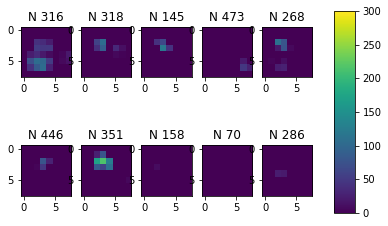

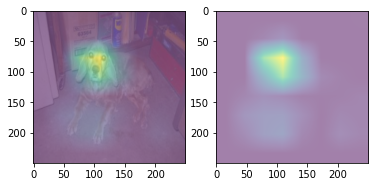

[1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1]


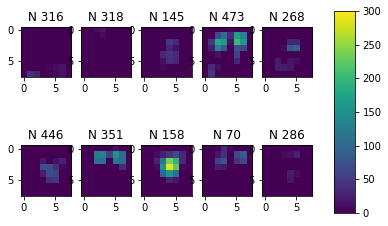

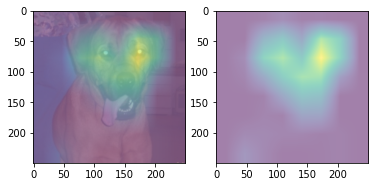

[0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0]


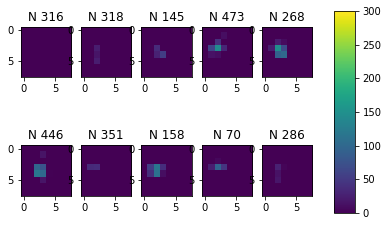

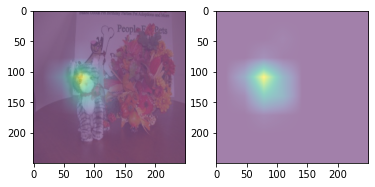

In [39]:
plotInterest(interestA,1)
plotInterest(interestA,2)
plotInterest(interestA,3)